### Imports

In [128]:
import csv
import re
import os
import pandas as pd
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import Choropleth
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, mean_squared_error, r2_score, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras.regularizers import L2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import GradientBoostingClassifier
import random

random.seed(69)

In [6]:
p = Path.cwd()
data_folder = p.parent.parent / "data"
shape_folder = p.parent.parent / "shape"

## Leitura do ficheiro

In [3]:
file = data_folder / "QuebrasJuntoInc.xlsx"
QuebrasFinal = pd.read_excel(file)
QuebrasFinal

,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,MT,Escavações,55,828.0,"0,0029345","0,0000443","0,0024563",...,157.9,0.000000,10.7,17.4,2.6,NaN,NaN,NaN,NaN,0.0
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,MT,Abate De Árvores,163,549.0,"0,0029335","0,0001770","0,0165009",...,260.2,1.000000,10.6,13.8,6.2,249.0,270.0,2.8,8.1,0.0
2,EDPD_2018_JAN_T_3,Felgueiras,2018-01-04,MT,Deslizamento De Terras,596,3459.0,"0,0192281","0,0002655","0,0359047",...,117.9,0.800000,14.0,14.8,12.9,197.0,180.0,3.9,14.4,4.0
3,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,BT,Veículos,178,102.0,"0,0000000","0,0000000","0,0000000",...,156.4,0.923077,12.4,15.1,9.1,288.0,225.0,3.6,13.9,13.2
4,EDPD_2018_JAN_T_5,Nisa,2018-01-09,MT,Aves,119,1731.0,"0,0044221","0,0001549","0,0100377",...,467.9,1.000000,4.9,7.8,2.2,137.0,118.0,4.1,15.4,15.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7300,EDPD_2017_NOV_T_62,Ovar,2017-11-29,BT,Veículos,220,2.0,0,0,0,...,141.7,1.000000,10.3,14.3,6.3,NaN,NaN,NaN,NaN,0.0
7301,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,BT,Veículos,92,1.0,0,0,0,...,134.6,0.000000,16.4,20.6,14.8,NaN,NaN,NaN,NaN,NaN
7302,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,BT,Veículos,121,1.0,0,0,0,...,134.6,0.000000,17.9,22.6,14.6,NaN,NaN,NaN,NaN,8.1
7303,EDPD_2017_NOV_T_65,Almeirim,2017-11-03,BT,Descarga Atmosférica Directa,154,1.0,0,0,0,...,175.1,1.000000,15.0,20.8,12.8,186.0,186.0,2.5,11.0,NaN


In [4]:
# Remover colunas desnecessárias
columnsRemove = ['Qualidade de Energia Elétrica', 'Qualidade de Serviço Comercial', 'Fundamentação']
QuebrasFinal = QuebrasFinal.drop(columns=columnsRemove)

# Substituir as vírgulas por pontos nas colunas supostamente numéricas
colunas_string = QuebrasFinal.iloc[:, 5:33].select_dtypes(include=['object']).columns
QuebrasFinal[colunas_string] = QuebrasFinal[colunas_string].replace(',', '.', regex=True)

QuebrasFinal

,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,MT,Escavações,55,828.0,0.0029345,0.0000443,0.0024563,...,157.9,0.000000,10.7,17.4,2.6,NaN,NaN,NaN,NaN,0.0
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,MT,Abate De Árvores,163,549.0,0.0029335,0.0001770,0.0165009,...,260.2,1.000000,10.6,13.8,6.2,249.0,270.0,2.8,8.1,0.0
2,EDPD_2018_JAN_T_3,Felgueiras,2018-01-04,MT,Deslizamento De Terras,596,3459.0,0.0192281,0.0002655,0.0359047,...,117.9,0.800000,14.0,14.8,12.9,197.0,180.0,3.9,14.4,4.0
3,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,BT,Veículos,178,102.0,0.0000000,0.0000000,0.0000000,...,156.4,0.923077,12.4,15.1,9.1,288.0,225.0,3.6,13.9,13.2
4,EDPD_2018_JAN_T_5,Nisa,2018-01-09,MT,Aves,119,1731.0,0.0044221,0.0001549,0.0100377,...,467.9,1.000000,4.9,7.8,2.2,137.0,118.0,4.1,15.4,15.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7300,EDPD_2017_NOV_T_62,Ovar,2017-11-29,BT,Veículos,220,2.0,0,0,0,...,141.7,1.000000,10.3,14.3,6.3,NaN,NaN,NaN,NaN,0.0
7301,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,BT,Veículos,92,1.0,0,0,0,...,134.6,0.000000,16.4,20.6,14.8,NaN,NaN,NaN,NaN,NaN
7302,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,BT,Veículos,121,1.0,0,0,0,...,134.6,0.000000,17.9,22.6,14.6,NaN,NaN,NaN,NaN,8.1
7303,EDPD_2017_NOV_T_65,Almeirim,2017-11-03,BT,Descarga Atmosférica Directa,154,1.0,0,0,0,...,175.1,1.000000,15.0,20.8,12.8,186.0,186.0,2.5,11.0,NaN


In [5]:
QuebrasFinal.dtypes

Código do Relatório          object
Concelho                     object
Data do incidente            object
Nível de Tensão              object
Causa do incidente           object
Duração incidente (min)      object
N.º clientes afetados       float64
TIEPI MT (min)               object
SAIFI MT (#)                 object
SAIDI MT (min)               object
END (MWh)                    object
SAIFI BT (#)                 object
SAIDI BT (min)               object
Decisão                      object
Dia                           int64
Mês                           int64
Ano                           int64
Distrito                     object
Densidade Populacional      float64
População Residente           int64
Setor Primário                int64
Setor Secundário              int64
Setor Terciário               int64
Indice de Envelhecimento    float64
Rural                       float64
T_MED                       float64
T_MAX                       float64
T_MIN                       

In [6]:
# Lista das colunas a serem convertidas
colunas_para_converter = ['Duração incidente (min)', 'TIEPI MT (min)', 'SAIFI MT (#)', 
                          'SAIDI MT (min)', 'END (MWh)', 'SAIFI BT (#)', 'SAIDI BT (min)']

# Converter as colunas para o tipo float
QuebrasFinal[colunas_para_converter] = QuebrasFinal[colunas_para_converter].apply(pd.to_numeric, errors='coerce')


## Estandardizar/Normalizar os dados

In [7]:
# Selecionar as colunas numéricas
colunas_numericas = QuebrasFinal.select_dtypes(include=[np.number]).columns
colunas_numericas

Index(['Duração incidente (min)', 'N.º clientes afetados', 'TIEPI MT (min)',
       'SAIFI MT (#)', 'SAIDI MT (min)', 'END (MWh)', 'SAIFI BT (#)',
       'SAIDI BT (min)', 'Dia', 'Mês', 'Ano', 'Densidade Populacional',
       'População Residente', 'Setor Primário', 'Setor Secundário',
       'Setor Terciário', 'Indice de Envelhecimento', 'Rural', 'T_MED',
       'T_MAX', 'T_MIN', 'DD_MED', 'DD_FFX', 'FF_MED', 'FF_MAX', 'PR_QTD'],
      dtype='object')

In [8]:
# Escolher o que queres
_ = False

if _ == True:
    # Criar o objeto do normalizador Min-Max
    scaler = MinMaxScaler()
    
    # Normalizar as colunas numéricas
    QuebrasFinal[colunas_numericas] = scaler.fit_transform(QuebrasFinal[colunas_numericas])

else:
    # Criar o objeto do estandardizador
    scaler = StandardScaler()
    
    # Estandardizar as colunas numéricas
    QuebrasFinal[colunas_numericas] = scaler.fit_transform(QuebrasFinal[colunas_numericas])

# Resultado final
QuebrasFinal

,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,MT,Escavações,-0.167430,-0.035849,-0.025291,-0.027507,-0.026427,...,-0.466877,-1.684053,-1.009103,-0.663530,-1.766912,NaN,NaN,NaN,NaN,-0.380286
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,MT,Abate De Árvores,-0.023458,-0.046206,-0.025292,-0.020875,-0.015301,...,0.564873,0.703961,-1.027227,-1.174879,-1.049541,0.301675,0.351434,-0.139841,-0.598378,-0.380286
2,EDPD_2018_JAN_T_3,Felgueiras,2018-01-04,MT,Deslizamento De Terras,0.553762,0.061818,-0.008440,-0.016452,0.000071,...,-0.870298,0.226358,-0.411014,-1.032837,0.285565,-0.177013,-0.552665,0.657334,1.193837,0.146958
3,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,BT,Veículos,-0.003462,-0.062799,-0.028326,-0.029721,-0.028373,...,-0.482005,0.520268,-0.700997,-0.990225,-0.471659,0.660690,-0.100615,0.439923,1.051597,1.359619
4,EDPD_2018_JAN_T_5,Nisa,2018-01-09,MT,Aves,-0.082113,-0.002328,-0.023752,-0.021980,-0.020421,...,2.659638,0.703961,-2.060289,-2.027127,-1.846620,-0.729344,-1.175489,0.802275,1.478315,1.715509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7300,EDPD_2017_NOV_T_62,Ovar,2017-11-29,BT,Veículos,0.052527,-0.066512,-0.028326,-0.029721,-0.028373,...,-0.630262,0.703961,-1.081598,-1.103858,-1.029614,NaN,NaN,NaN,NaN,-0.380286
7301,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,BT,Veículos,-0.118106,-0.066549,-0.028326,-0.029721,-0.028373,...,-0.701870,-1.684053,0.023960,-0.208997,0.664177,NaN,NaN,NaN,NaN,NaN
7302,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,BT,Veículos,-0.079447,-0.066549,-0.028326,-0.029721,-0.028373,...,-0.701870,-1.684053,0.295818,0.075085,0.624323,NaN,NaN,NaN,NaN,0.687383
7303,EDPD_2017_NOV_T_65,Almeirim,2017-11-03,BT,Descarga Atmosférica Directa,-0.035456,-0.066549,-0.028326,-0.029721,-0.028373,...,-0.293405,0.703961,-0.229775,-0.180589,0.265638,-0.278273,-0.492392,-0.357252,0.226609,NaN


## Imputação dos dados

In [9]:
# Criar o objeto do imputador por regressão
imputer_mice = IterativeImputer()

# Aplicar o método MICE para imputar os valores ausentes em todas as colunas numéricas
QuebrasFinal[colunas_numericas] = imputer_mice.fit_transform(QuebrasFinal[colunas_numericas])

# Resultado final
QuebrasFinal


C:\Users\diogo\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,MT,Escavações,-0.167430,-0.035849,-0.025291,-0.027507,-0.026427,...,-0.466877,-1.684053,-1.009103,-0.663530,-1.766912,-0.170715,-0.001784,-0.139797,-0.094998,-0.380286
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,MT,Abate De Árvores,-0.023458,-0.046206,-0.025292,-0.020875,-0.015301,...,0.564873,0.703961,-1.027227,-1.174879,-1.049541,0.301675,0.351434,-0.139841,-0.598378,-0.380286
2,EDPD_2018_JAN_T_3,Felgueiras,2018-01-04,MT,Deslizamento De Terras,0.553762,0.061818,-0.008440,-0.016452,0.000071,...,-0.870298,0.226358,-0.411014,-1.032837,0.285565,-0.177013,-0.552665,0.657334,1.193837,0.146958
3,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,BT,Veículos,-0.003462,-0.062799,-0.028326,-0.029721,-0.028373,...,-0.482005,0.520268,-0.700997,-0.990225,-0.471659,0.660690,-0.100615,0.439923,1.051597,1.359619
4,EDPD_2018_JAN_T_5,Nisa,2018-01-09,MT,Aves,-0.082113,-0.002328,-0.023752,-0.021980,-0.020421,...,2.659638,0.703961,-2.060289,-2.027127,-1.846620,-0.729344,-1.175489,0.802275,1.478315,1.715509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7300,EDPD_2017_NOV_T_62,Ovar,2017-11-29,BT,Veículos,0.052527,-0.066512,-0.028326,-0.029721,-0.028373,...,-0.630262,0.703961,-1.081598,-1.103858,-1.029614,-0.290553,-0.263786,-0.217849,-0.319109,-0.380286
7301,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,BT,Veículos,-0.118106,-0.066549,-0.028326,-0.029721,-0.028373,...,-0.701870,-1.684053,0.023960,-0.208997,0.664177,-0.149299,-0.107256,-0.271951,-0.228287,0.355803
7302,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,BT,Veículos,-0.079447,-0.066549,-0.028326,-0.029721,-0.028373,...,-0.701870,-1.684053,0.295818,0.075085,0.624323,-0.141388,-0.111701,-0.262819,-0.069782,0.687383
7303,EDPD_2017_NOV_T_65,Almeirim,2017-11-03,BT,Descarga Atmosférica Directa,-0.035456,-0.066549,-0.028326,-0.029721,-0.028373,...,-0.293405,0.703961,-0.229775,-0.180589,0.265638,-0.278273,-0.492392,-0.357252,0.226609,0.601223


In [10]:
QuebrasFinal["Data do incidente"] = pd.to_datetime(QuebrasFinal["Data do incidente"])
BT = QuebrasFinal[(QuebrasFinal["Distrito"] == "Lisboa")]
BT.drop(["Nível de Tensão", "TIEPI MT (min)", "SAIFI MT (#)", "SAIDI MT (min)"], axis = 1, inplace=True)
BT

C:\Users\diogo\AppData\Local\Temp\ipykernel_38416\3341529584.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BT.drop(["Nível de Tensão", "TIEPI MT (min)", "SAIFI MT (#)", "SAIDI MT (min)"], axis = 1, inplace=True)


,Código do Relatório,Concelho,Data do incidente,Causa do incidente,Duração incidente (min),N.º clientes afetados,END (MWh),SAIFI BT (#),SAIDI BT (min),Decisão,...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
3,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,Veículos,-0.003462,-0.062799,-0.040624,-0.037415,-0.025634,Não Aprovado,...,-0.482005,0.520268,-0.700997,-0.990225,-0.471659,0.660690,-0.100615,0.439923,1.051597,1.359619
44,EDPD_2018_FEV_T_17,Amadora,2018-02-16,Escavações,-0.188759,0.024399,-0.033922,-0.039363,-0.027721,Não Aprovado,...,-0.623202,-1.684053,-0.918483,-0.592509,-0.929980,1.231433,0.692983,-0.937015,-0.569930,-0.380286
45,EDPD_2018_FEV_T_18,Lisboa,2018-02-15,Escavações,-0.098110,-0.039598,0.008841,-0.027077,-0.020790,Não Aprovado,...,-0.379132,-1.684053,-0.519758,-0.791367,-0.093047,0.080742,-0.552665,-0.212311,-0.968200,-0.380286
51,EDPD_2018_FEV_T_24,Cadaval,2018-02-14,Escavações,-0.090112,0.004725,-0.008945,-0.007145,-0.021813,Não Aprovado,...,0.313744,0.703961,-0.628501,-0.848183,-0.332171,0.099153,-0.100615,0.802275,0.226609,-0.380286
79,EDPD_2018_MAR_T_12,Mafra,2018-03-05,Descarga Atmosférica Directa,0.443117,-0.047208,0.092829,-0.028403,-0.002121,Não Aprovado,...,-1.101257,0.703961,-0.773492,-1.103858,-0.471659,0.402936,0.692983,2.686506,2.786916,1.359619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7214,EDPD_2017_OUT_T_93,Odivelas,2017-10-24,Escavações,0.024533,-0.066549,-0.040624,-0.039628,-0.027741,Não Aprovado,...,-0.832981,-1.684053,0.658296,0.643251,0.743885,-1.649897,-1.908813,-0.502193,-0.854409,-0.380286
7251,EDPD_2017_NOV_T_1,Lisboa,2017-11-06,Escavações,-0.175428,-0.066437,-0.032907,-0.039628,-0.027765,Não Aprovado,...,-0.381150,-1.684053,-0.374766,-0.450468,-0.132901,-1.778774,-1.848540,0.222511,0.255057,-0.380286
7252,EDPD_2017_NOV_T_2,Lisboa,2017-11-23,Escavações,-0.234084,-0.064321,-0.039437,-0.038303,-0.027737,Não Aprovado,...,-0.381150,-1.684053,0.259570,-0.095364,0.883374,-0.130985,-0.040342,1.599449,1.819689,2.058218
7253,EDPD_2017_NOV_T_3,Oeiras,2017-11-14,Animais Não Aves,-0.170096,0.008437,-0.031720,-0.020146,-0.024991,Não Aprovado,...,-0.579835,-1.684053,-0.537881,-0.578305,-0.372025,-1.548636,-1.908813,0.005100,-0.313900,-0.380286


In [11]:
BT.columns

Index(['Código do Relatório', 'Concelho', 'Data do incidente',
       'Causa do incidente', 'Duração incidente (min)',
       'N.º clientes afetados', 'END (MWh)', 'SAIFI BT (#)', 'SAIDI BT (min)',
       'Decisão', 'Dia', 'Mês', 'Ano', 'Distrito', 'Densidade Populacional',
       'População Residente', 'Setor Primário', 'Setor Secundário',
       'Setor Terciário', 'Indice de Envelhecimento', 'Rural', 'T_MED',
       'T_MAX', 'T_MIN', 'DD_MED', 'DD_FFX', 'FF_MED', 'FF_MAX', 'PR_QTD'],
      dtype='object')

In [12]:
# Selecionar apenas as colunas relevantes
features = ['T_MED', 'T_MAX', 'T_MIN', 'DD_MED', 'DD_FFX', 'FF_MED', 'FF_MAX', 'PR_QTD']
target = 'SAIDI BT (min)'
X = BT[features].values
y = BT[target].values

# Preparar os dados em sequências
def create_sequences(X, y, time_steps=7):
    X_sequence, y_sequence = [], []
    for i in range(len(X) - time_steps):
        X_sequence.append(X[i:i+time_steps])
        y_sequence.append(y[i+time_steps])
    return np.array(X_sequence), np.array(y_sequence)

time_steps = 1  # Janela de tempo de x dias
X_seq, y_seq = create_sequences(X, y, time_steps)

# Dividir os dados em conjuntos de treinamento e teste
split_ratio = 0.8
split = int(split_ratio * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

# Construir o modelo LSTM
model = Sequential([
    LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

# Compilar o modelo
model.compile(optimizer='adam', loss='mse')

# Treinar o modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Avaliar o modelo
loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss}')


Epoch 1/50


C:\Users\diogo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0016 - val_loss: 6.9721e-04
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.9910e-04 - val_loss: 5.5771e-04
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2611e-04 - val_loss: 5.3968e-04
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7405e-04 - val_loss: 5.3224e-04
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 - val_loss: 5.4444e-04
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011 - val_loss: 5.3495e-04
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.8162e-04 - val_loss: 5.1490e-04
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0233e-04 - val_loss: 5.1958e-04
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1648e-04 - val_loss: 5.1653e-04
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017 - val_loss: 5.0970e-04
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1838e-04 - val_loss: 5.2185e-04
Epoch 12/50


In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Fazer previsões com o modelo
y_pred = model.predict(X_test)

# Calcular o Erro Absoluto Médio (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calcular a Raiz do Erro Quadrático Médio (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calcular o Erro Percentual Absoluto Médio (MAPE)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Calcular o Coeficiente de Determinação (R²)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')
print(f'R-squared (R²): {r2}')


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Mean Absolute Error (MAE): 0.006995980955516076
Root Mean Squared Error (RMSE): 0.009027245450243467
Mean Absolute Percentage Error (MAPE): 33.30328627406009
R-squared (R²): -3.016199554148548


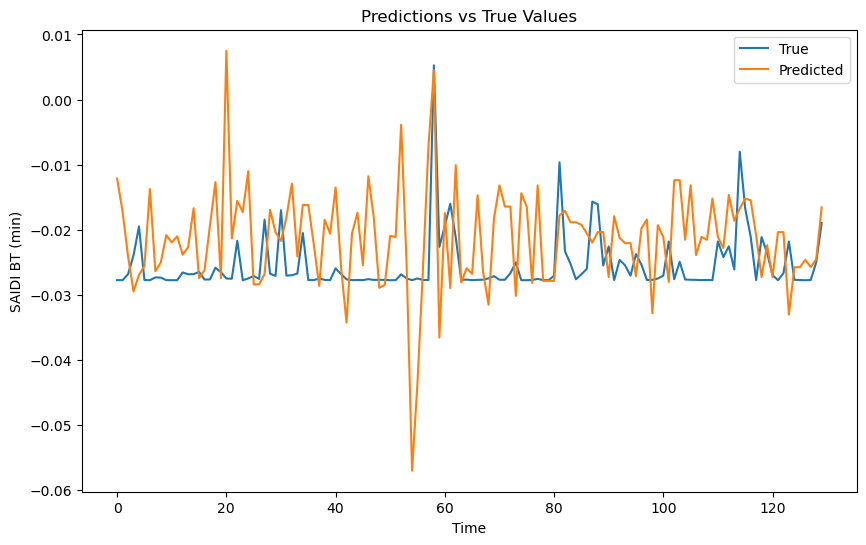

In [14]:
# Plotar as previsões vs. os valores reais
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('SAIDI BT (min)')
plt.title('Predictions vs True Values')
plt.legend()
plt.savefig('LSTMindica')
plt.show()


In [15]:
BT.columns

Index(['Código do Relatório', 'Concelho', 'Data do incidente',
       'Causa do incidente', 'Duração incidente (min)',
       'N.º clientes afetados', 'END (MWh)', 'SAIFI BT (#)', 'SAIDI BT (min)',
       'Decisão', 'Dia', 'Mês', 'Ano', 'Distrito', 'Densidade Populacional',
       'População Residente', 'Setor Primário', 'Setor Secundário',
       'Setor Terciário', 'Indice de Envelhecimento', 'Rural', 'T_MED',
       'T_MAX', 'T_MIN', 'DD_MED', 'DD_FFX', 'FF_MED', 'FF_MAX', 'PR_QTD'],
      dtype='object')

- - -

## Teste 2 (Nº Eventos) --

In [16]:
file = data_folder / "AllDaysEventos.parquet"
QuebrasFinal = pd.read_parquet(file)
QuebrasFinal

,Data do incidente,Concelho,Distrito,Nível de Tensão,Número de Eventos,Dia,Mês,Ano,Densidade Populacional,População Residente,...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,2014-01-01,Albergaria-A-Velha,Aveiro,Sem Eventos Excecionais,0,1,1,2014,157.7,25053.0,...,132.3,1.00,13.9,15.1,12.6,194.0,225.0,4.3,15.4,16.2
1,2014-01-01,Anadia,Aveiro,Sem Eventos Excecionais,0,1,1,2014,131.0,28378.0,...,209.7,1.00,13.9,15.1,12.6,194.0,225.0,4.3,15.4,16.2
2,2014-01-01,Arouca,Aveiro,Sem Eventos Excecionais,0,1,1,2014,66.3,21815.0,...,130.5,1.00,13.9,15.1,12.6,194.0,225.0,4.3,15.4,16.2
3,2014-01-01,Aveiro,Aveiro,Sem Eventos Excecionais,0,1,1,2014,400.3,79092.0,...,124.7,0.00,13.9,15.1,12.6,194.0,225.0,4.3,15.4,16.2
4,2014-01-01,Castelo De Paiva,Aveiro,Sem Eventos Excecionais,0,1,1,2014,141.5,16275.0,...,110.9,1.00,13.9,15.1,12.6,194.0,225.0,4.3,15.4,16.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1008000,2023-12-31,Reguengos De Monsaraz,Évora,Sem Eventos Excecionais,0,31,12,2023,21.2,9836.0,...,208.9,1.00,10.6,13.5,6.8,275.0,339.0,1.6,7.0,1.1
1008001,2023-12-31,Vendas Novas,Évora,Sem Eventos Excecionais,0,31,12,2023,51.2,11394.0,...,240.6,1.00,10.6,13.5,6.8,275.0,339.0,1.6,7.0,1.1
1008002,2023-12-31,Viana Do Alentejo,Évora,Sem Eventos Excecionais,0,31,12,2023,13.9,5470.0,...,197.7,1.00,10.6,13.5,6.8,275.0,339.0,1.6,7.0,1.1
1008003,2023-12-31,Vila Viçosa,Évora,Sem Eventos Excecionais,0,31,12,2023,37.7,7349.0,...,238.9,1.00,10.6,13.5,6.8,275.0,339.0,1.6,7.0,1.1


In [17]:
QuebrasFinal["Distrito"].unique()

array(['Aveiro', 'Beja', 'Braga', 'Bragança', 'Castelo Branco', 'Coimbra',
       'Faro', 'Guarda', 'Leiria', 'Lisboa', 'Portalegre', 'Porto',
       'Santarém', 'Setúbal', 'Viana Do Castelo', 'Vila Real', 'Viseu',
       'Évora'], dtype=object)

In [18]:
Concelho = 'Lisboa'

BT = QuebrasFinal[(QuebrasFinal["Distrito"] == Concelho) & (QuebrasFinal["Ano"] == 2018)]
BT = BT_grouped = BT.groupby(['Data do incidente', 'Dia', 'Mês', 'Ano', 
                               'T_MED', 'T_MAX', 'T_MIN', 'DD_MED', 'DD_FFX', 'FF_MED', 'FF_MAX', 'PR_QTD']).agg({'Número de Eventos': 'sum'}).reset_index()

# Não está a dar os 365 dias não sei porquê
BT

,Data do incidente,Dia,Mês,Ano,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD,Número de Eventos
0,2018-01-01,1,1,2018,12.0,16.3,8.1,277.0,270.0,1.5,7.0,0.0,0
1,2018-01-02,2,1,2018,13.0,15.9,9.1,269.0,309.0,1.8,6.9,0.0,0
2,2018-01-03,3,1,2018,14.5,17.0,12.9,284.0,309.0,2.1,6.0,0.1,0
3,2018-01-04,4,1,2018,14.3,16.3,13.3,251.0,264.0,2.8,7.9,0.8,0
4,2018-01-05,5,1,2018,12.4,15.1,9.1,288.0,225.0,3.6,13.9,13.2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,2018-12-27,27,12,2018,10.9,14.3,8.1,49.0,321.0,1.2,4.7,0.1,0
356,2018-12-28,28,12,2018,13.8,17.3,10.3,18.0,354.0,2.2,7.6,0.0,0
357,2018-12-29,29,12,2018,11.0,15.1,8.0,54.0,79.0,4.3,9.3,0.0,0
358,2018-12-30,30,12,2018,11.0,15.8,7.8,53.0,51.0,4.5,10.2,0.0,0


## Estandardizar/Normalizar os dados

In [19]:
# Selecionar as colunas numéricas
colunas_numericas = BT.select_dtypes(include=[np.number]).columns
colunas_numericas

Index(['Dia', 'Mês', 'Ano', 'T_MED', 'T_MAX', 'T_MIN', 'DD_MED', 'DD_FFX',
       'FF_MED', 'FF_MAX', 'PR_QTD', 'Número de Eventos'],
      dtype='object')

## Imputação dos dados

In [20]:
# Criar o objeto do imputador por regressão
imputer_mice = IterativeImputer()

# Aplicar o método MICE para imputar os valores ausentes em todas as colunas numéricas
BT[colunas_numericas] = imputer_mice.fit_transform(BT[colunas_numericas])

# Resultado final
BT


,Data do incidente,Dia,Mês,Ano,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD,Número de Eventos
0,2018-01-01,1.0,1.0,2018.0,12.0,16.3,8.1,277.0,270.0,1.5,7.0,0.0,0.0
1,2018-01-02,2.0,1.0,2018.0,13.0,15.9,9.1,269.0,309.0,1.8,6.9,0.0,0.0
2,2018-01-03,3.0,1.0,2018.0,14.5,17.0,12.9,284.0,309.0,2.1,6.0,0.1,0.0
3,2018-01-04,4.0,1.0,2018.0,14.3,16.3,13.3,251.0,264.0,2.8,7.9,0.8,0.0
4,2018-01-05,5.0,1.0,2018.0,12.4,15.1,9.1,288.0,225.0,3.6,13.9,13.2,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,2018-12-27,27.0,12.0,2018.0,10.9,14.3,8.1,49.0,321.0,1.2,4.7,0.1,0.0
356,2018-12-28,28.0,12.0,2018.0,13.8,17.3,10.3,18.0,354.0,2.2,7.6,0.0,0.0
357,2018-12-29,29.0,12.0,2018.0,11.0,15.1,8.0,54.0,79.0,4.3,9.3,0.0,0.0
358,2018-12-30,30.0,12.0,2018.0,11.0,15.8,7.8,53.0,51.0,4.5,10.2,0.0,0.0


In [21]:
BT["Número de Eventos"].unique()

array([0., 1., 2.])

In [22]:
BT.columns

Index(['Data do incidente', 'Dia', 'Mês', 'Ano', 'T_MED', 'T_MAX', 'T_MIN',
       'DD_MED', 'DD_FFX', 'FF_MED', 'FF_MAX', 'PR_QTD', 'Número de Eventos'],
      dtype='object')

In [23]:
# Selecionar apenas as colunas relevantes
features = ['Dia', 'Mês', 'Ano', 'T_MED', 'T_MAX', 'T_MIN', 'DD_MED', 'DD_FFX', 'FF_MED', 'FF_MAX', 'PR_QTD']
target = 'Número de Eventos'
X = BT[features].values
y = BT[target].values

# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar os dados de entrada
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Calcular a proporção de classes
class_weights = len(y_train) / (5 * np.bincount(y_train.astype(int)))

# Definir a função de peso de amostra
def sample_weight_function(y):
    return class_weights[y.astype(int)]

# Construir o modelo LSTM
model = Sequential([
    LSTM(units=50, return_sequences=True, kernel_regularizer=L2(0.001), input_shape=(X_train.shape[1], 1)),
    Dropout(0.3),
    LSTM(units=50, kernel_regularizer=L2(0.001)),
    Dropout(0.3),
    Dense(1, kernel_regularizer=L2(0.001), activation='linear')  # Ativação linear para regressão
])

# Compilar o modelo
model.compile(optimizer=Adam(), loss='mse')

# Treinar o modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1, sample_weight=sample_weight_function(y_train))

# Avaliar o modelo
loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss}')

Epoch 1/20


C:\Users\diogo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 1.7803 - val_loss: 0.2149
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8009 - val_loss: 0.1934
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5743 - val_loss: 0.1765
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1498 - val_loss: 0.2140
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5412 - val_loss: 0.2861
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3635 - val_loss: 0.2652
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4079 - val_loss: 0.3081
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4565 - val_loss: 0.2796
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3739 - val_loss: 0.2290
Epoch 10/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6269 - val_loss: 0.2482
Epoch 11/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5651 - val_loss: 0.2647
Epoch 12/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3498 - val_loss: 0.2519
Epoch 13/20
8/8 ━━━━━━━

In [24]:
# Fazer previsões com o modelo
y_pred = model.predict(X_test)

# Calcular o erro quadrático médio (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Calcular o coeficiente de determinação (R²)
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Mean Squared Error: 0.7156043311913519
R-squared: -4.983375569187045


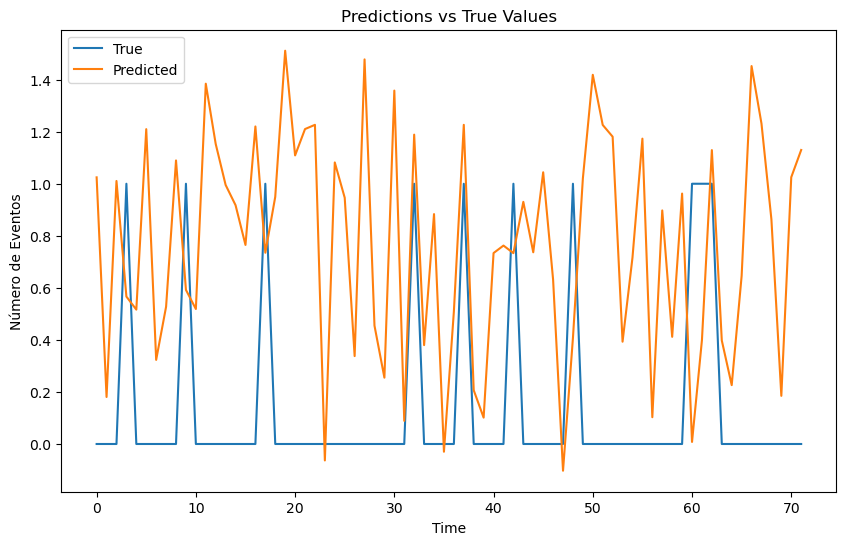

In [25]:
# Plotar as previsões vs. os valores reais
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Número de Eventos')
plt.title('Predictions vs True Values')
plt.legend()
plt.savefig('LSTMcount')
plt.show()


In [26]:
count_eventos = BT['Número de Eventos'].value_counts()
print(count_eventos)


Número de Eventos
0.0    323
1.0     35
2.0      2
Name: count, dtype: int64


C:\Users\diogo\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error (MSE): 0.19707628031004087
R-squared: -4.983375569187045


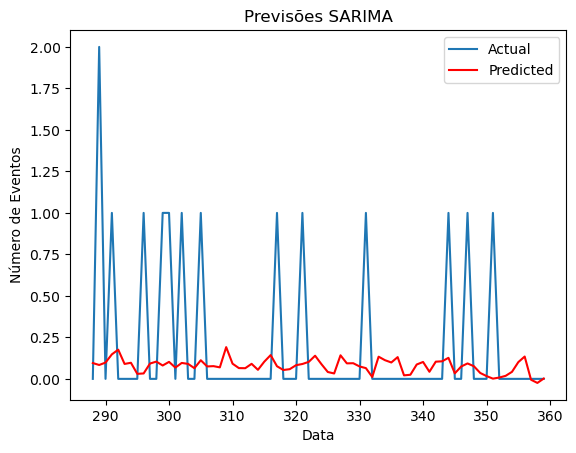

In [27]:
# Selecionar apenas as colunas relevantes
data = BT[['Número de Eventos', 'T_MED', 'T_MAX', 'T_MIN', 'DD_MED', 'DD_FFX', 'FF_MED', 'FF_MAX', 'PR_QTD']]

# Dividir os dados em conjunto de treinamento e teste
train_size = int(len(data) * 0.8)
train_data, test_data = data.iloc[:train_size], data.iloc[train_size:]

# Ajustar o modelo SARIMA
order = (1, 0, 0)  # Ordem dos termos autoregressivos (AR), diferenciação (I) e média móvel (MA)
seasonal_order = (1, 0, 0, 12)  # Ordem dos termos sazonais SAR, diferenciação (I) e média móvel (SMA), e periodicidade sazonal
model = SARIMAX(train_data['Número de Eventos'], exog=train_data.drop(columns=['Número de Eventos']), order=order, seasonal_order=seasonal_order)
sarima_result = model.fit()

# Fazer previsões
predictions = sarima_result.get_forecast(steps=len(test_data), exog=test_data.drop(columns=['Número de Eventos']))
predicted_values = predictions.predicted_mean
actual_values = test_data['Número de Eventos']

# Avaliar o modelo
mse = mean_squared_error(actual_values, predicted_values)
print(f'Mean Squared Error (MSE): {mse}')

# Calcular o coeficiente de determinação (R²)
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

# Plotar as previsões
plt.plot(actual_values.index, actual_values, label='Actual')
plt.plot(predicted_values.index, predicted_values, label='Predicted', color='red')
plt.legend()
plt.xlabel('Data')
plt.ylabel('Número de Eventos')
plt.title('Previsões SARIMA')
plt.show()

## Teste 3 (Classificação) --

In [161]:
file = data_folder / "AllDaysEventos.parquet"
QuebrasFinal = pd.read_parquet(file)
QuebrasFinal

,Data do incidente,Concelho,Distrito,Nível de Tensão,Número de Eventos,Dia,Mês,Ano,Densidade Populacional,População Residente,...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,2014-01-01,Albergaria-A-Velha,Aveiro,Sem Eventos Excecionais,0,1,1,2014,157.7,25053.0,...,132.3,1.00,13.9,15.1,12.6,194.0,225.0,4.3,15.4,16.2
1,2014-01-01,Anadia,Aveiro,Sem Eventos Excecionais,0,1,1,2014,131.0,28378.0,...,209.7,1.00,13.9,15.1,12.6,194.0,225.0,4.3,15.4,16.2
2,2014-01-01,Arouca,Aveiro,Sem Eventos Excecionais,0,1,1,2014,66.3,21815.0,...,130.5,1.00,13.9,15.1,12.6,194.0,225.0,4.3,15.4,16.2
3,2014-01-01,Aveiro,Aveiro,Sem Eventos Excecionais,0,1,1,2014,400.3,79092.0,...,124.7,0.00,13.9,15.1,12.6,194.0,225.0,4.3,15.4,16.2
4,2014-01-01,Castelo De Paiva,Aveiro,Sem Eventos Excecionais,0,1,1,2014,141.5,16275.0,...,110.9,1.00,13.9,15.1,12.6,194.0,225.0,4.3,15.4,16.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1008000,2023-12-31,Reguengos De Monsaraz,Évora,Sem Eventos Excecionais,0,31,12,2023,21.2,9836.0,...,208.9,1.00,10.6,13.5,6.8,275.0,339.0,1.6,7.0,1.1
1008001,2023-12-31,Vendas Novas,Évora,Sem Eventos Excecionais,0,31,12,2023,51.2,11394.0,...,240.6,1.00,10.6,13.5,6.8,275.0,339.0,1.6,7.0,1.1
1008002,2023-12-31,Viana Do Alentejo,Évora,Sem Eventos Excecionais,0,31,12,2023,13.9,5470.0,...,197.7,1.00,10.6,13.5,6.8,275.0,339.0,1.6,7.0,1.1
1008003,2023-12-31,Vila Viçosa,Évora,Sem Eventos Excecionais,0,31,12,2023,37.7,7349.0,...,238.9,1.00,10.6,13.5,6.8,275.0,339.0,1.6,7.0,1.1


In [162]:
QuebrasFinal = QuebrasFinal[(QuebrasFinal["Distrito"] == "Lisboa")]

In [163]:
def existeEvento(x):
    if x > 0:
        return 1
    else:
        return 0

QuebrasFinal["HouveEventos?"] = QuebrasFinal["Número de Eventos"].apply(existeEvento)
QuebrasFinal.drop('Número de Eventos', axis = 1, inplace=True)
QuebrasFinal

C:\Users\diogo\AppData\Local\Temp\ipykernel_35292\2667743126.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  QuebrasFinal["HouveEventos?"] = QuebrasFinal["Número de Eventos"].apply(existeEvento)
C:\Users\diogo\AppData\Local\Temp\ipykernel_35292\2667743126.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  QuebrasFinal.drop('Número de Eventos', axis = 1, inplace=True)


,Data do incidente,Concelho,Distrito,Nível de Tensão,Dia,Mês,Ano,Densidade Populacional,População Residente,Setor Primário,...,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD,HouveEventos?
131,2014-01-01,Alenquer,Lisboa,Sem Eventos Excecionais,1,1,2014,141.4,43021.0,608.0,...,1.000000,14.4,15.2,12.0,232.0,236.0,5.4,13.4,3.8,0
132,2014-01-01,Amadora,Lisboa,BT,1,1,2014,7227.9,171913.0,103.0,...,0.000000,14.4,15.2,12.0,232.0,236.0,5.4,13.4,3.8,1
133,2014-01-01,Arruda Dos Vinhos,Lisboa,Sem Eventos Excecionais,1,1,2014,172.7,13467.0,153.0,...,1.000000,14.4,15.2,12.0,232.0,236.0,5.4,13.4,3.8,0
134,2014-01-01,Azambuja,Lisboa,Sem Eventos Excecionais,1,1,2014,81.9,21503.0,361.0,...,1.000000,14.4,15.2,12.0,232.0,236.0,5.4,13.4,3.8,0
135,2014-01-01,Cadaval,Lisboa,Sem Eventos Excecionais,1,1,2014,79.2,13847.0,524.0,...,1.000000,14.4,15.2,12.0,232.0,236.0,5.4,13.4,3.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007871,2023-12-31,Oeiras,Lisboa,Sem Eventos Excecionais,31,12,2023,3755.2,172289.0,261.0,...,0.000000,11.9,14.3,8.9,298.0,304.0,1.7,6.8,1.1,0
1007872,2023-12-31,Sintra,Lisboa,Sem Eventos Excecionais,31,12,2023,1215.4,388001.0,891.0,...,0.000000,11.9,14.3,8.9,298.0,304.0,1.7,6.8,1.1,0
1007873,2023-12-31,Sobral De Monte Agraço,Lisboa,Sem Eventos Excecionais,31,12,2023,216.7,11288.0,172.0,...,1.000000,11.9,14.3,8.9,298.0,304.0,1.7,6.8,1.1,0
1007874,2023-12-31,Torres Vedras,Lisboa,Sem Eventos Excecionais,31,12,2023,209.7,85372.0,2672.0,...,0.923077,11.9,14.3,8.9,298.0,304.0,1.7,6.8,1.1,0


## Estandardizar/Normalizar os dados

In [164]:
# Selecionar as colunas numéricas
colunas_numericas = QuebrasFinal.select_dtypes(include=[np.number]).columns
colunas_numericas = colunas_numericas.drop("HouveEventos?")
colunas_numericas

Index(['Dia', 'Mês', 'Ano', 'Densidade Populacional', 'População Residente',
       'Setor Primário', 'Setor Secundário', 'Setor Terciário',
       'Indice de Envelhecimento', 'Rural', 'T_MED', 'T_MAX', 'T_MIN',
       'DD_MED', 'DD_FFX', 'FF_MED', 'FF_MAX', 'PR_QTD'],
      dtype='object')

In [165]:
# Escolher o que queres
_ = False

if _ == True:
    # Criar o objeto do normalizador Min-Max
    scaler = MinMaxScaler()
    
    # Normalizar as colunas numéricas
    QuebrasFinal[colunas_numericas] = scaler.fit_transform(QuebrasFinal[colunas_numericas])

else:
    # Criar o objeto do estandardizador
    scaler = StandardScaler()
    
    # Estandardizar as colunas numéricas
    QuebrasFinal[colunas_numericas] = scaler.fit_transform(QuebrasFinal[colunas_numericas])

# Resultado final
QuebrasFinal

C:\Users\diogo\AppData\Local\Temp\ipykernel_35292\3607669919.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  QuebrasFinal[colunas_numericas] = scaler.fit_transform(QuebrasFinal[colunas_numericas])


,Data do incidente,Concelho,Distrito,Nível de Tensão,Dia,Mês,Ano,Densidade Populacional,População Residente,Setor Primário,...,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD,HouveEventos?
131,2014-01-01,Alenquer,Lisboa,Sem Eventos Excecionais,-1.673749,-1.601728,-1.566743,-0.707703,-0.690013,-0.054762,...,1.018801,-0.553595,-1.109860,-0.288162,0.156441,-0.123497,1.701249,0.811003,0.353487,0
132,2014-01-01,Amadora,Lisboa,BT,-1.673749,-1.601728,-1.566743,2.356511,0.208608,-0.910669,...,-0.999289,-0.553595,-1.109860,-0.288162,0.156441,-0.123497,1.701249,0.811003,0.353487,1
133,2014-01-01,Arruda Dos Vinhos,Lisboa,Sem Eventos Excecionais,-1.673749,-1.601728,-1.566743,-0.694169,-0.896061,-0.825926,...,1.018801,-0.553595,-1.109860,-0.288162,0.156441,-0.123497,1.701249,0.811003,0.353487,0
134,2014-01-01,Azambuja,Lisboa,Sem Eventos Excecionais,-1.673749,-1.601728,-1.566743,-0.733431,-0.840035,-0.473394,...,1.018801,-0.553595,-1.109860,-0.288162,0.156441,-0.123497,1.701249,0.811003,0.353487,0
135,2014-01-01,Cadaval,Lisboa,Sem Eventos Excecionais,-1.673749,-1.601728,-1.566743,-0.734598,-0.893411,-0.197130,...,1.018801,-0.553595,-1.109860,-0.288162,0.156441,-0.123497,1.701249,0.811003,0.353487,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007871,2023-12-31,Oeiras,Lisboa,Sem Eventos Excecionais,1.735513,1.588076,1.566999,0.854910,0.211229,-0.642880,...,-0.999289,-1.084471,-1.255529,-1.025378,0.663085,0.489903,-1.512653,-1.226897,-0.112751,0
1007872,2023-12-31,Sintra,Lisboa,Sem Eventos Excecionais,1.735513,1.588076,1.566999,-0.243304,1.715151,0.424886,...,-0.999289,-1.084471,-1.255529,-1.025378,0.663085,0.489903,-1.512653,-1.226897,-0.112751,0
1007873,2023-12-31,Sobral De Monte Agraço,Lisboa,Sem Eventos Excecionais,1.735513,1.588076,1.566999,-0.675143,-0.911252,-0.793723,...,1.018801,-1.084471,-1.255529,-1.025378,0.663085,0.489903,-1.512653,-1.226897,-0.112751,0
1007874,2023-12-31,Torres Vedras,Lisboa,Sem Eventos Excecionais,1.735513,1.588076,1.566999,-0.678170,-0.394747,3.443442,...,0.863564,-1.084471,-1.255529,-1.025378,0.663085,0.489903,-1.512653,-1.226897,-0.112751,0


## Imputação dos dados

In [166]:
# Criar o objeto do imputador por regressão
imputer_mice = IterativeImputer()

# Aplicar o método MICE para imputar os valores ausentes em todas as colunas numéricas
QuebrasFinal[colunas_numericas] = imputer_mice.fit_transform(QuebrasFinal[colunas_numericas])

# Resultado final
QuebrasFinal

C:\Users\diogo\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\diogo\AppData\Local\Temp\ipykernel_35292\490769108.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  QuebrasFinal[colunas_numericas] = imputer_mice.fit_transform(QuebrasFinal[colunas_numericas])


,Data do incidente,Concelho,Distrito,Nível de Tensão,Dia,Mês,Ano,Densidade Populacional,População Residente,Setor Primário,...,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD,HouveEventos?
131,2014-01-01,Alenquer,Lisboa,Sem Eventos Excecionais,-1.673749,-1.601728,-1.566743,-0.707703,-0.690013,-0.054762,...,1.018801,-0.553595,-1.109860,-0.288162,0.156441,-0.123497,1.701249,0.811003,0.353487,0
132,2014-01-01,Amadora,Lisboa,BT,-1.673749,-1.601728,-1.566743,2.356511,0.208608,-0.910669,...,-0.999289,-0.553595,-1.109860,-0.288162,0.156441,-0.123497,1.701249,0.811003,0.353487,1
133,2014-01-01,Arruda Dos Vinhos,Lisboa,Sem Eventos Excecionais,-1.673749,-1.601728,-1.566743,-0.694169,-0.896061,-0.825926,...,1.018801,-0.553595,-1.109860,-0.288162,0.156441,-0.123497,1.701249,0.811003,0.353487,0
134,2014-01-01,Azambuja,Lisboa,Sem Eventos Excecionais,-1.673749,-1.601728,-1.566743,-0.733431,-0.840035,-0.473394,...,1.018801,-0.553595,-1.109860,-0.288162,0.156441,-0.123497,1.701249,0.811003,0.353487,0
135,2014-01-01,Cadaval,Lisboa,Sem Eventos Excecionais,-1.673749,-1.601728,-1.566743,-0.734598,-0.893411,-0.197130,...,1.018801,-0.553595,-1.109860,-0.288162,0.156441,-0.123497,1.701249,0.811003,0.353487,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007871,2023-12-31,Oeiras,Lisboa,Sem Eventos Excecionais,1.735513,1.588076,1.566999,0.854910,0.211229,-0.642880,...,-0.999289,-1.084471,-1.255529,-1.025378,0.663085,0.489903,-1.512653,-1.226897,-0.112751,0
1007872,2023-12-31,Sintra,Lisboa,Sem Eventos Excecionais,1.735513,1.588076,1.566999,-0.243304,1.715151,0.424886,...,-0.999289,-1.084471,-1.255529,-1.025378,0.663085,0.489903,-1.512653,-1.226897,-0.112751,0
1007873,2023-12-31,Sobral De Monte Agraço,Lisboa,Sem Eventos Excecionais,1.735513,1.588076,1.566999,-0.675143,-0.911252,-0.793723,...,1.018801,-1.084471,-1.255529,-1.025378,0.663085,0.489903,-1.512653,-1.226897,-0.112751,0
1007874,2023-12-31,Torres Vedras,Lisboa,Sem Eventos Excecionais,1.735513,1.588076,1.566999,-0.678170,-0.394747,3.443442,...,0.863564,-1.084471,-1.255529,-1.025378,0.663085,0.489903,-1.512653,-1.226897,-0.112751,0


In [167]:
QuebrasFinal["HouveEventos?"].unique()

array([0, 1], dtype=int64)

In [168]:
QuebrasFinal.columns

Index(['Data do incidente', 'Concelho', 'Distrito', 'Nível de Tensão', 'Dia',
       'Mês', 'Ano', 'Densidade Populacional', 'População Residente',
       'Setor Primário', 'Setor Secundário', 'Setor Terciário',
       'Indice de Envelhecimento', 'Rural', 'T_MED', 'T_MAX', 'T_MIN',
       'DD_MED', 'DD_FFX', 'FF_MED', 'FF_MAX', 'PR_QTD', 'HouveEventos?'],
      dtype='object')

In [169]:
colunas_numericas

Index(['Dia', 'Mês', 'Ano', 'Densidade Populacional', 'População Residente',
       'Setor Primário', 'Setor Secundário', 'Setor Terciário',
       'Indice de Envelhecimento', 'Rural', 'T_MED', 'T_MAX', 'T_MIN',
       'DD_MED', 'DD_FFX', 'FF_MED', 'FF_MAX', 'PR_QTD'],
      dtype='object')

In [170]:
colunas_variaveis = colunas_numericas.tolist()
colunas_variaveis.append('HouveEventos?')
colunas_variaveis

['Dia',
 'Mês',
 'Ano',
 'Densidade Populacional',
 'População Residente',
 'Setor Primário',
 'Setor Secundário',
 'Setor Terciário',
 'Indice de Envelhecimento',
 'Rural',
 'T_MED',
 'T_MAX',
 'T_MIN',
 'DD_MED',
 'DD_FFX',
 'FF_MED',
 'FF_MAX',
 'PR_QTD',
 'HouveEventos?']

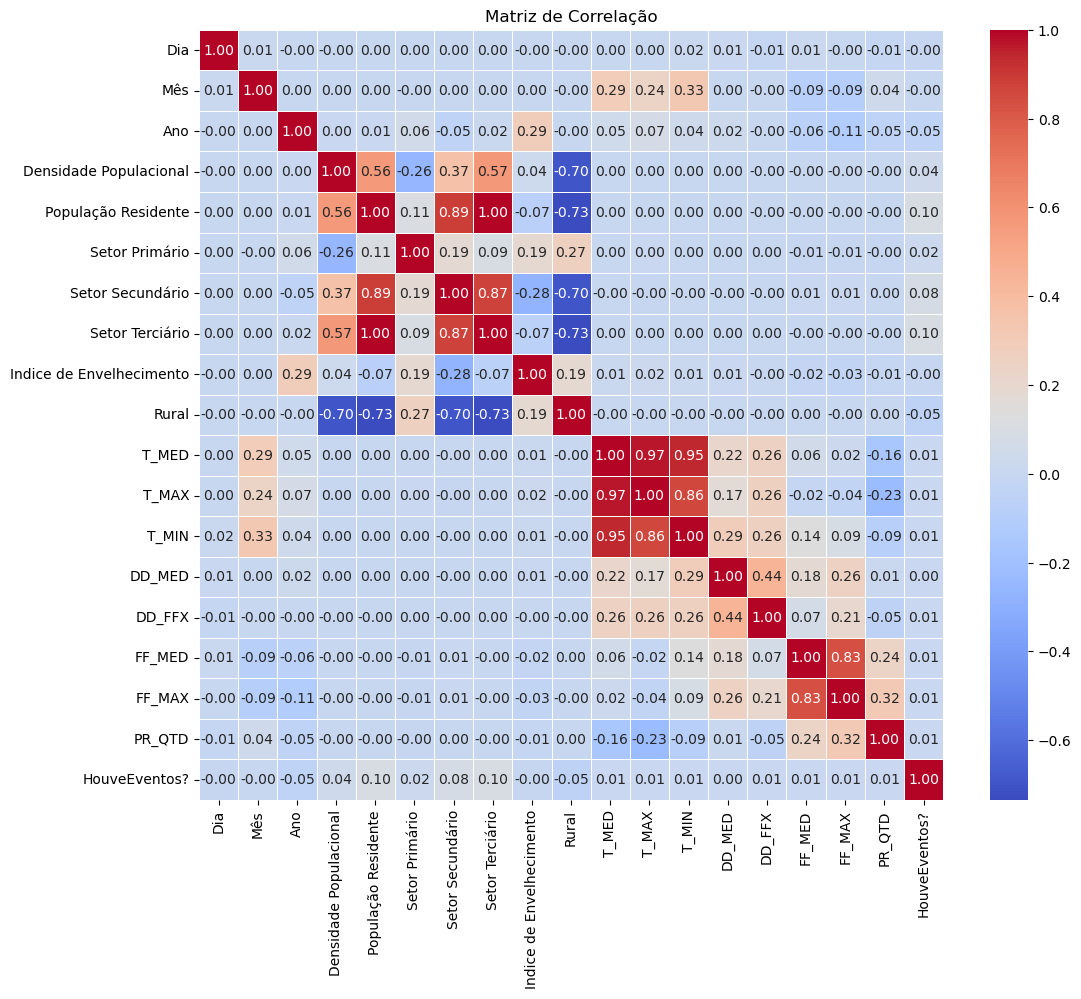

In [171]:
correlation_matrix = QuebrasFinal[colunas_variaveis].corr()
# Passo 5: Plotar um gráfico de correlações
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlação")
plt.savefig("Matriz de Correlação")
plt.show()

### Original

In [172]:
# Passo 2: Dividir os dados em conjuntos de treino e teste
X = QuebrasFinal.drop(columns=['HouveEventos?', 'Data do incidente', 'Concelho', 'Distrito', 'Nível de Tensão'])
y = QuebrasFinal['HouveEventos?']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Passo 3: Criar e treinar o modelo Gradient Boosting
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

GradientBoostingClassifier()

In [173]:
# Passo 4: Avaliar o desempenho do modelo
y_pred = gb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Imprimir as métricas
print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Relatório de classificação:\n", classification_report(y_test, y_pred))

Acurácia: 0.9869952087611226
Precisão: 0.0
Recall: 0.0
F1-score: 0.0
Relatório de classificação:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     11537
           1       0.00      0.00      0.00       151

    accuracy                           0.99     11688
   macro avg       0.49      0.50      0.50     11688
weighted avg       0.97      0.99      0.98     11688



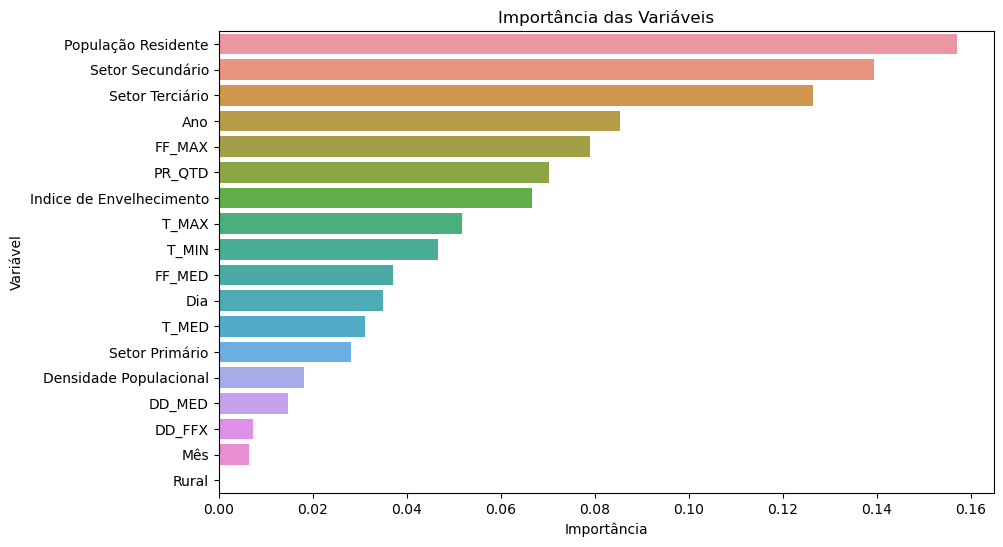

In [174]:
# Calcular a importância das variáveis
importances = gb_model.feature_importances_

# Criar um DataFrame com as importâncias das variáveis
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Ordenar as variáveis por importância
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plotar a importância das variáveis
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.xlabel('Importância')
plt.ylabel('Variável')
plt.title('Importância das Variáveis')
plt.savefig("OGimportanciaVariaveis")
plt.show()


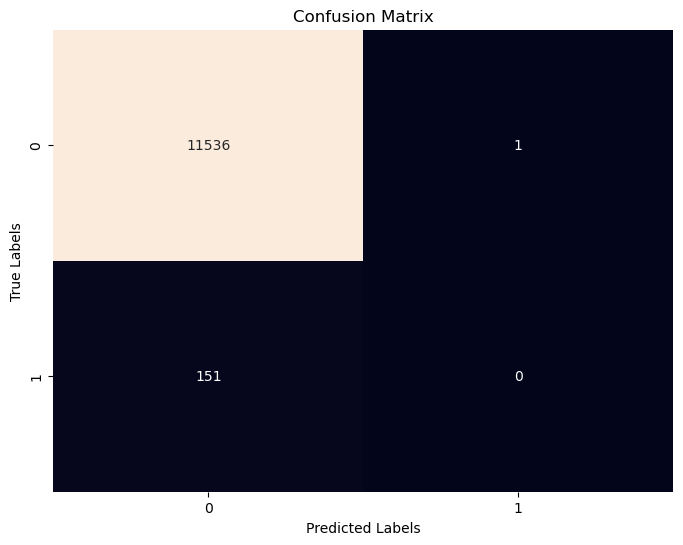

In [175]:
# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig("OGconfusionMatrix")
plt.show()


### Oversampling

In [177]:
QuebrasFinal = QuebrasFinal[colunas_variaveis]

In [178]:
# Separar as classes minoritárias e maioritárias
minor_class = QuebrasFinal[QuebrasFinal['HouveEventos?'] == 1]
major_class = QuebrasFinal[QuebrasFinal['HouveEventos?'] == 0]

# Fazer oversampling da classe minoritária
oversampled_minor_class = resample(minor_class, replace=True, n_samples=len(major_class), random_state=42)

# Juntar os dados da classe maioritária com a classe minoritária oversampled
oversampled_data = pd.concat([major_class, oversampled_minor_class])

# Separar as features (X) e o target (y)
X = oversampled_data.drop(columns=['HouveEventos?'])
y = oversampled_data['HouveEventos?']


In [179]:
oversampled_data

,Dia,Mês,Ano,Densidade Populacional,População Residente,Setor Primário,Setor Secundário,Setor Terciário,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD,HouveEventos?
131,-1.673749,-1.601728,-1.566743,-0.707703,-0.690013,-0.054762,-0.507473,-0.705917,-0.852318,1.018801,-0.553595,-1.109860,-0.288162,0.156441,-0.123497,1.701249,0.811003,0.353487,0
133,-1.673749,-1.601728,-1.566743,-0.694169,-0.896061,-0.825926,-0.996525,-0.861318,-1.084619,1.018801,-0.553595,-1.109860,-0.288162,0.156441,-0.123497,1.701249,0.811003,0.353487,0
134,-1.673749,-1.601728,-1.566743,-0.733431,-0.840035,-0.473394,-0.920434,-0.825005,0.259822,1.018801,-0.553595,-1.109860,-0.288162,0.156441,-0.123497,1.701249,0.811003,0.353487,0
135,-1.673749,-1.601728,-1.566743,-0.734598,-0.893411,-0.197130,-1.007609,-0.878856,1.752355,1.018801,-0.553595,-1.109860,-0.288162,0.156441,-0.123497,1.701249,0.811003,0.353487,0
136,-1.673749,-1.601728,-1.566743,0.156581,0.463382,-0.515765,0.319446,0.447773,-0.753590,-0.999289,-0.553595,-1.109860,-0.288162,0.156441,-0.123497,1.701249,0.811003,0.353487,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366168,0.371808,0.428148,-0.522162,-0.583085,-0.036900,-0.461529,0.172618,0.008701,-1.180443,-0.999289,1.442499,1.447445,1.138708,1.062259,0.589129,0.832627,0.687494,-0.302700,1
85170,-1.219181,1.298094,-1.566743,-0.651534,-0.438391,0.507934,-0.148311,-0.464137,-1.679890,1.018801,-0.850886,-0.867078,-0.740004,0.993171,0.895829,-0.122857,0.625740,-0.268164,1
763601,1.508229,0.138165,0.870612,-0.735031,-0.894645,-0.068321,-1.020810,-0.882299,3.189716,1.018801,0.784213,0.897139,0.805772,1.016201,0.895829,0.832627,0.780126,-0.302700,1
660655,0.599092,0.138165,0.522418,-0.245293,0.421767,-0.249671,0.527172,0.372511,0.007195,-0.999289,2.291901,2.143421,2.399110,-1.340462,-1.440502,-0.296582,0.656617,-0.130019,1


In [180]:
# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar e treinar o modelo Gradient Boosting
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

GradientBoostingClassifier()

In [181]:
# Passo 4: Avaliar o desempenho do modelo
y_pred = gb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Imprimir as métricas
print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Relatório de classificação:\n", classification_report(y_test, y_pred))

Acurácia: 0.774317719821807
Precisão: 0.758453702930617
Recall: 0.796213515645543
F1-score: 0.7768750534507826
Relatório de classificação:
               precision    recall  f1-score   support

           0       0.79      0.75      0.77     11712
           1       0.76      0.80      0.78     11409

    accuracy                           0.77     23121
   macro avg       0.77      0.77      0.77     23121
weighted avg       0.78      0.77      0.77     23121



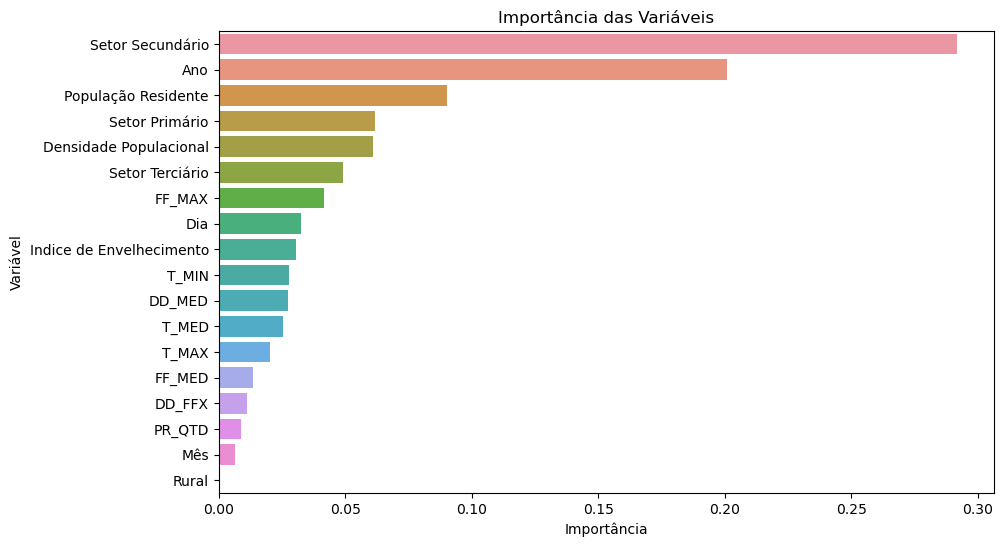

In [182]:
# Calcular a importância das variáveis
importances = gb_model.feature_importances_

# Criar um DataFrame com as importâncias das variáveis
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Ordenar as variáveis por importância
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plotar a importância das variáveis
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.xlabel('Importância')
plt.ylabel('Variável')
plt.title('Importância das Variáveis')
plt.savefig("OVERimportanciaVariaveis")
plt.show()


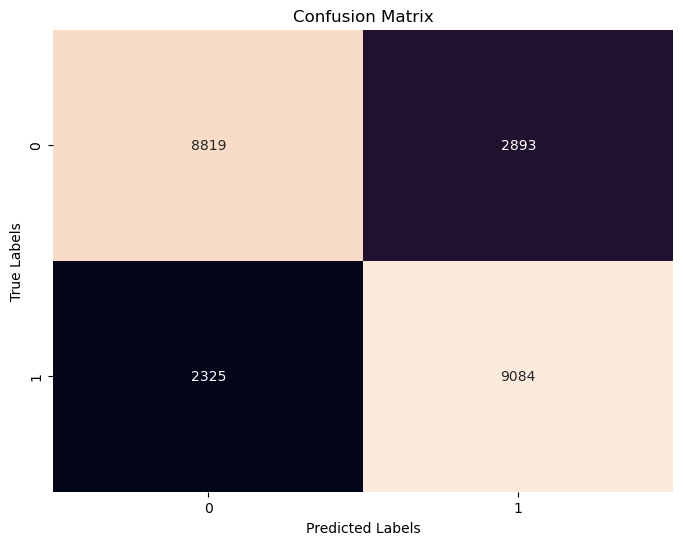

In [183]:
# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig("OVERconfusionMatrix")
plt.show()

In [184]:
conf_matrix

array([[8819, 2893],
       [2325, 9084]], dtype=int64)

### Undersampling

In [154]:
# Separar as classes minoritárias e maioritárias
minor_class = QuebrasFinal[QuebrasFinal['HouveEventos?'] == 1]
major_class = QuebrasFinal[QuebrasFinal['HouveEventos?'] == 0]

# Fazer undersampling da classe maioritária
undersampled_major_class = resample(major_class, replace=False, n_samples=len(minor_class), random_state=42)

# Juntar os dados da classe maioritária com a classe minoritária
undersampled_data = pd.concat([minor_class, undersampled_major_class])

# Separar as features (X) e o target (y)
X = undersampled_data.drop(columns=['HouveEventos?'])
y = undersampled_data['HouveEventos?']


In [155]:
undersampled_data

,Dia,Mês,Ano,Densidade Populacional,População Residente,Setor Primário,Setor Secundário,Setor Terciário,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD,HouveEventos?
132,-1.673749,-1.601728,-1.566743,2.356511,0.208608,-0.910669,0.249084,0.170397,-0.268662,-0.999289,-0.553595,-1.109860,-0.288162,0.156441,-0.123497,1.701249,0.811003,0.353487,1
413,-1.560107,-1.601728,-1.566743,1.577237,2.794846,0.084217,1.886732,2.772637,0.782499,-0.999289,-0.341245,-0.964191,0.377711,0.210176,-0.069374,2.656733,1.058022,0.923334,1
414,-1.560107,-1.601728,-1.566743,-0.253206,0.400502,-0.322550,0.808001,0.316527,-0.518386,-0.999289,-0.341245,-0.964191,0.377711,0.210176,-0.069374,2.656733,1.058022,0.923334,1
1517,-1.105539,-1.601728,-1.566743,1.577237,2.794846,0.084217,1.886732,2.772637,0.782499,-0.999289,-0.404950,-0.883263,0.306367,-0.035470,-0.475300,2.309284,1.150654,3.289061,1
1526,-1.105539,-1.601728,-1.566743,-0.583517,-0.039082,-0.454750,0.496786,-0.015920,-1.525991,-0.999289,-0.404950,-0.883263,0.306367,-0.035470,-0.475300,2.309284,1.150654,3.289061,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
823768,-1.332823,-1.021763,1.218806,-0.687639,-0.887862,-0.832705,-1.012840,-0.853428,-0.701323,1.018801,-1.318057,-1.174602,-1.168065,1.108318,0.940932,1.266938,1.397672,-0.302700,0
290804,0.371808,1.298094,-0.870356,-0.251692,0.404574,-0.322550,0.808001,0.316527,-0.349968,-0.999289,-0.574830,-0.705223,-0.716223,0.402086,-0.321950,-0.296582,-0.269702,0.526168,0
880631,1.167302,0.718130,1.218806,-0.688937,-0.800288,0.814705,-0.849822,-0.815842,1.313887,1.018801,0.444452,0.492502,0.353929,1.131347,0.895829,0.572040,0.872758,-0.302700,0
625875,0.144524,-1.021763,0.522418,-0.733560,-0.840481,-0.405599,-0.950074,-0.823517,0.916072,1.018801,-0.723475,-0.672852,-0.930254,-1.294404,-1.494626,1.788111,2.076972,-0.302700,0


In [156]:
# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar e treinar o modelo Gradient Boosting
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

GradientBoostingClassifier()

In [157]:
# Passo 4: Avaliar o desempenho do modelo
y_pred = gb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Imprimir as métricas
print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Relatório de classificação:\n", classification_report(y_test, y_pred))

Acurácia: 0.6653543307086615
Precisão: 0.703125
Recall: 0.656934306569343
F1-score: 0.679245283018868
Relatório de classificação:
               precision    recall  f1-score   support

           0       0.63      0.68      0.65       117
           1       0.70      0.66      0.68       137

    accuracy                           0.67       254
   macro avg       0.67      0.67      0.66       254
weighted avg       0.67      0.67      0.67       254



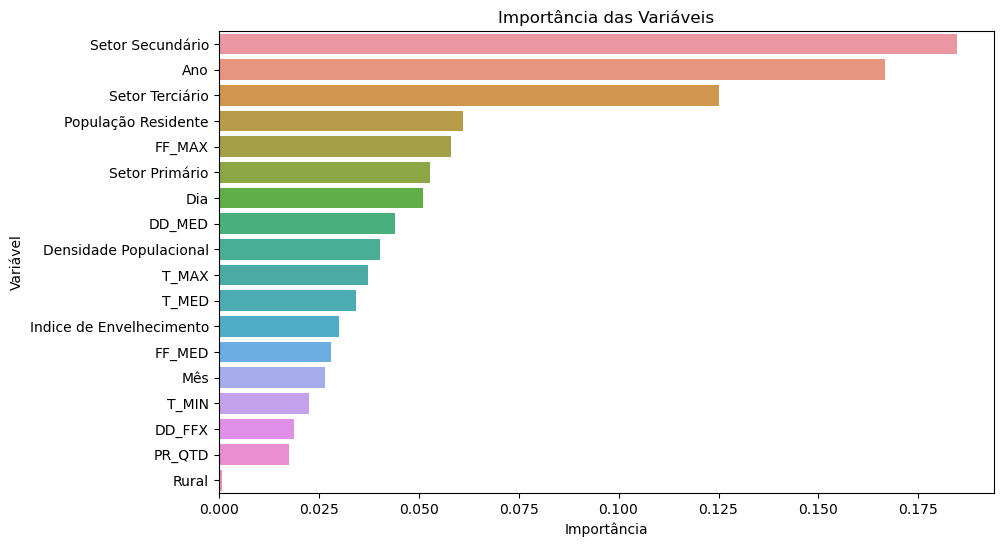

In [158]:
# Calcular a importância das variáveis
importances = gb_model.feature_importances_

# Criar um DataFrame com as importâncias das variáveis
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Ordenar as variáveis por importância
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plotar a importância das variáveis
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.xlabel('Importância')
plt.ylabel('Variável')
plt.title('Importância das Variáveis')
plt.show()


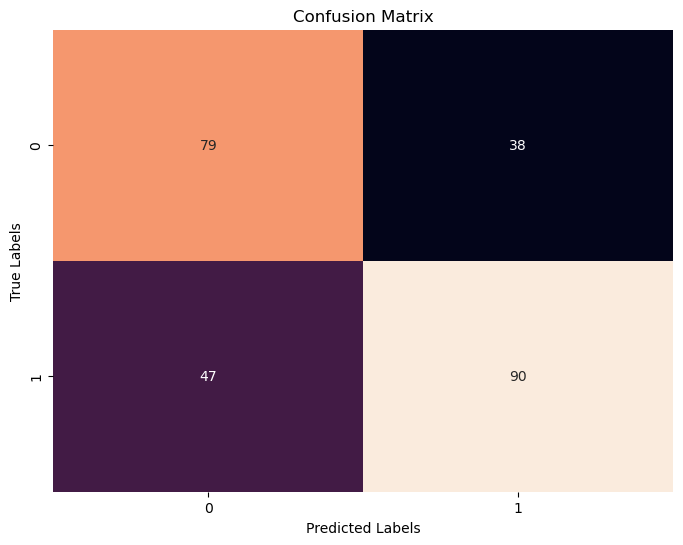

In [159]:
# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()